# 高斯混合模型

##  一：概述

高斯混合模型(GMM)在图像分割、对象识别、视频分析等方面均有应用，对于任意给定的数据样本集合，根据其分布概率， 可以计算每个样本数据向量的概率分布，从而根据概率分布对其进行分类，但是这些概率分布是混合在一起的，要从中分离出单个样本的概率分布就实现了样本数据聚类，而概率分布描述我们可以使用高斯函数实现，这个就是高斯混合模型-GMM。

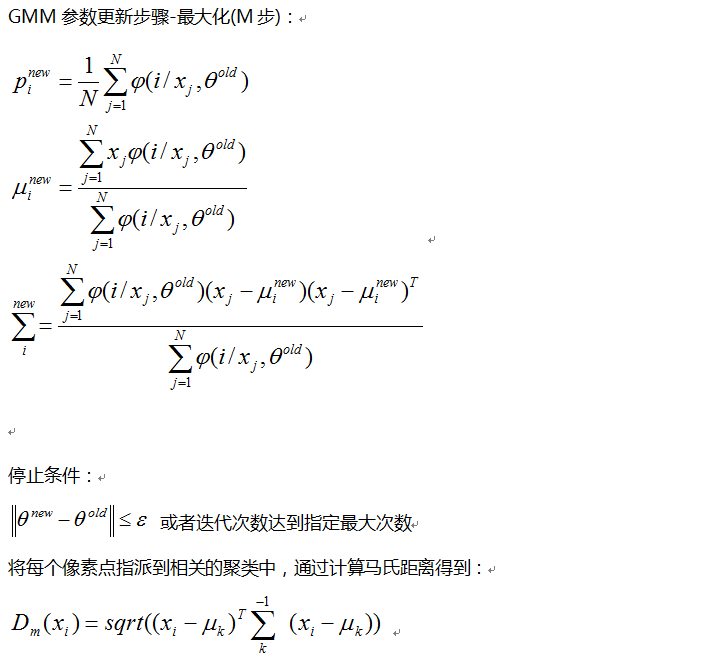

这种方法也称为D-EM即基于距离的期望最大化。

 ## 三：算法步骤

1. 初始化变量定义-指定的聚类数目K与数据维度D
2. 初始化均值、协方差、先验概率分布
3. 迭代E-M步骤
         - E步计算期望
         - M步更新均值、协方差、先验概率分布
         - 检测是否达到停止条件（最大迭代次数与最小误差满足），达到则退出迭代，否则继续E-M步骤

4. 打印最终分类结果

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import skimage.io
import imageio
import math

In [3]:
src = imageio.imread('../datas/face5.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [5]:
def make_gaussians(cluster_n, img_size):
    points = []
    ref_distrs = []
    for _i in range(cluster_n):
        mean = (0.1 + 0.8*np.random.rand(2)) * img_size
        a = (np.random.rand(2, 2)-0.5)*img_size*0.1
        cov = np.dot(a.T, a) + img_size*0.05*np.eye(2)
        n = 100 + np.random.randint(900)
        pts = np.random.multivariate_normal(mean, cov, n)
        points.append( pts )
        ref_distrs.append( (mean, cov) )
    points = np.float32( np.vstack(points) )
    return points, ref_distrs

In [6]:
def draw_gaussain(img, mean, cov, color):
    x, y = np.int32(mean)
    w, u, _vt = cv2.SVDecomp(cov)
    ang = np.arctan2(u[1, 0], u[0, 0])*(180/np.pi)
    s1, s2 = np.sqrt(w)*3.0
    cv2.ellipse(img, (x, y), (s1, s2), ang, 0, 360, color, 1, cv2.LINE_AA)

sampling distributions...
EM (opencv) ...
ready!



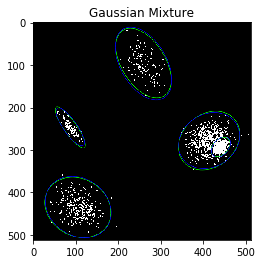

In [21]:
if __name__ == '__main__':
    cluster_n = 5
    img_size = 512

    print('sampling distributions...')
    points, ref_distrs = make_gaussians(cluster_n, img_size)

    print('EM (opencv) ...')
    em = cv2.ml.EM_create()
    em.setClustersNumber(cluster_n)
    em.setCovarianceMatrixType(cv2.ml.EM_COV_MAT_GENERIC)
    em.trainEM(points)
    means = em.getMeans()
    covs = em.getCovs()  # Known bug: https://github.com/opencv/opencv/pull/4232
    found_distrs = zip(means, covs)
    print('ready!\n')

    img = np.zeros((img_size, img_size, 3), np.uint8)
    for x, y in np.int32(points):
        cv2.circle(img, (x, y), 1, (255, 255, 255), -1)
    for m, cov in ref_distrs:
        draw_gaussain(img, m, cov, (0, 255, 0))
    for m, cov in found_distrs:
        draw_gaussain(img, m, cov, (0, 0, 255))
    plt.imshow(img)
    plt.title('Gaussian Mixture')

In [21]:
def gaussian_mixture(img,num_clusters = 4,colors = np.array([(255,0,0),(0,255,0),(0,0,255),(255,255,0)])):
    rows,cols,dims = img.shape
    src = np.float32(img)
    points = np.zeros((rows*cols,dims),dtype=np.float32)
    results = np.zeros_like(src)
    
    for i in range(rows):
        for j in range(cols):
            pixel = src[i,j]
            index = i * cols + j
            points[i,0] = pixel[0]
            points[i,1] = pixel[1]
            points[i,2] = pixel[2]
    em = cv2.ml.EM_create()
    em.setClustersNumber(num_clusters)
    em.setCovarianceMatrixType(cv2.ml.EM_COV_MAT_SPHERICAL)
    em.setTermCriteria((cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 100, 0.1))
    em.trainEM(points)
    means = em.getMeans()
    covs = em.getCovs()  # Known bug: https://github.com/open
    sample = np.zeros((1,dims),dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            pixel = src[i,j]
            sample[0,0] = pixel[0]
            sample[0,1] = pixel[1]
            sample[0,2] = pixel[2]
            response = np.round(em.predict2(sample,None)[1]).astype(np.int32)
            for idx,value in enumerate(response[0]):
                if value == 1:
                    color = colors[idx]
                    results[i,j] = color
    results = np.uint8(results)
    return results

In [22]:
dst = gaussian_mixture(src)

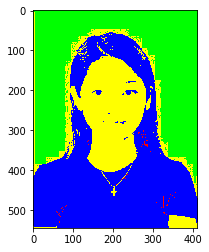

In [23]:
plt.imshow(dst)

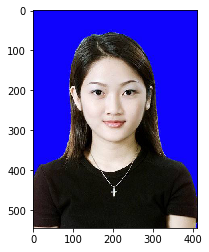

In [20]:
plt.imshow(src)

In [45]:
colors = np.array([(255,0,0),(0,255,0),(0,0,255),(255,255,0)])
colors[np.array([0,0,1])]

# print(colors[[0,0,1]])

array([[255,   0,   0],
       [255,   0,   0],
       [  0, 255,   0]])

In [ ]:
plt.imshow(dst)

In [24]:
help(cv2.ml.EM_create().train)

Help on built-in function train:

train(...) method of cv2.ml_EM instance
    train(trainData[, flags]) -> retval
    .   @brief Trains the statistical model
    .   
    .   @param trainData training data that can be loaded from file using TrainData::loadFromCSV or
    .   created with TrainData::create.
    .   @param flags optional flags, depending on the model. Some of the models can be updated with the
    .   new training samples, not completely overwritten (such as NormalBayesClassifier or ANN_MLP).
    
    
    
    train(samples, layout, responses) -> retval
    .   @brief Trains the statistical model
    .   
    .   @param samples training samples
    .   @param layout See ml::SampleTypes.
    .   @param responses vector of responses associated with the training samples.



参考：

[1]. https://www.cnblogs.com/wjy-lulu/p/7009038.html

[2]. https://blog.csdn.net/jia20003/article/details/72771737